<a href="https://colab.research.google.com/github/zscialom/RL_Research/blob/test/RESEARCH_PAPER_CODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimal Execution Problem: Liquidation

### Import the necessary libraries

In [1]:
import numpy as np
import matplotlib
import pandas as pd
from statsmodels.othermod.betareg import BetaModel
from scipy.stats import norm
import copy
import matplotlib.pyplot as plt 
from tqdm import tqdm 
import time

In [2]:
# import packages

import scipy.io as sio  # for loading matlab data
import csv
from matplotlib.ticker import FuncFormatter # for custom bar plot labels

import matplotlib.pyplot as plt  # for plotting

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
from statsmodels.tsa import stattools
from statsmodels.graphics import gofplots
from scipy import stats
from statsmodels.tsa import arima_model
from statsmodels.regression import linear_model
import statsmodels.api as sm

In [3]:
%matplotlib inline

### Load the data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
ticker = 'GOOG'
period = '20141103'

In [6]:
data = sio.loadmat('/content/drive/Shared drives/ProjectML/Project/Nov-2014/'+ticker+'_'+period+'.mat')

In [7]:
data['LOB']['EventTime']

array([[array([[34200100],
               [34200200],
               [34200300],
               ...,
               [57599800],
               [57599900],
               [57600000]], dtype=int32)]], dtype=object)

In [8]:
LOB=data['LOB']

# Refer to"DataDescription.pdf" in the GitHub repo
# The file contains a structure called LOB where each field has entries corresponding to one second of the trading day

# time stamp is milliseconds from midnight at the start of the second
time_adj = 1e-3              # time adjustment: the time unit in raw data is millisecond
price_adj = 1e-4             # price correction: the price quoted in raw data is in price*1e4 form
t = (np.array((LOB['EventTime'][0][0][:,0]))-3600000*9.5)*time_adj    # converting time in seconds (hence 1e-3), measured from NASDAQ opening at 9:30am (hence 3600000*9.5)
bid = np.array(LOB['BuyPrice'][0][0]*price_adj)                       # bid price in the given 0.1 second interval 
bidvol = np.array(LOB['BuyVolume'][0][0]*1.0)                         # bid volumes in the given 0.1 second interval                  
ask = np.array(LOB['SellPrice'][0][0]*price_adj)                      # ask price in the given 0.1 second interval
askvol = np.array(LOB['SellVolume'][0][0]*1.0)                        # ask volumes in the given 0.1 second interval
nMO = np.array(LOB['NumberMO'][0][0]*1.0)                             # total number of MOs submitted in the given 0.1 second interval
vMO = np.array(LOB['VolumeMO'][0][0]*1.0)                             # total volume of MOs submitted in the given 0.1 second interval
MO=np.array(LOB['MO'][0][0]*1.0)                                      # information about market orders: number of MOs in the given 0.1 second interval
dt = t[1]-t[0]                                                        # dt = 0.1 second
print(dt)
print(t[0])
print(t[-1])

0.1
0.1
23400.0


## Order Flow

<Figure size 432x288 with 0 Axes>

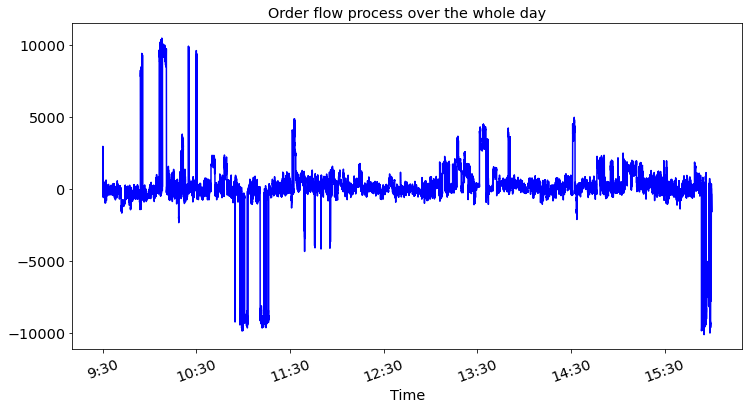

In [9]:
# Order Flow
# definition: sum of the 10 best bid volumes - sum of the 10 best ask volumes

nVol_OF = 10   # number of best volumes considered (10 in our case)
order_flow = np.sum(bidvol[:,:nVol_OF],axis=1)-np.sum(askvol[:,:nVol_OF],axis=1) 

plt.figure()
fig, ax = plt.subplots(figsize=(12,6))
plt.plot(order_flow,'b')
plt.title('Order flow process over the whole day')
plt.xlabel('Time')
plt.xticks([0, 36000, 72000, 108000, 144000, 180000,216000], ['9:30', '10:30', '11:30','12:30','13:30', '14:30', '15:30'], rotation=20)
plt.savefig('/content/drive/Shared drives/ProjectML/Project/Temporary_Plots_Figures/'+ticker+'/Order_flow_process.png')

### Midprice, Microprice and LO Imbalance


In [10]:
# Midprice
midprice = 0.5*(bid[:,0]+ask[:,0])
#print(midprice)

# Microprice
microprice = (bid[:,0]*askvol[:,0]+ask[:,0]*bidvol[:,0])/(bidvol[:,0]+askvol[:,0])

# LO imbalance for each time stamp
rho = np.array((bidvol[:,0]-askvol[:,0])/(bidvol[:,0]+askvol[:,0]),ndmin=2).T


## Setting Up the Market Impact Problem

We assume $N$ number of shares to liquidate, $M$ possible microprices and $T$ time steps. All combinations of state and time can then be represented as a three-dimensional grid of size $N_1\times M\times T$. A time-independent action-value function $ Q(s_t, a_t)$ with $N_2$ possible actions can then be stored as a rank-three tensor of dimension $N_1\times M \times N_2$. 

## Setting some global parameters

### Trading Window: Starting at 13:01 with 50 time steps



-> Details about the choice of the trading window can be found on the report.

In [11]:
# Work on the trading window

# Timestamp is 0.1 second: time needs to be multiplied by 10 to get everysecond
secondFreq = 10 # variable needed to work with seconds
oneMinute = 60 

# START TRADING: 13h00
# between 9:30 and 13:00: 3.5 hours so, 210 minutes
# work with 13:01 for convenience
tradStart = 211
initTime = (tradStart*secondFreq*oneMinute)-1       # time for 13:01 am

# Setting the end of the trading window:  

#thirtyMin = (178*60+55)*secondFreq                 # 16:00 - 2 hours 58 minutes 55 seconds 5steps
#thirtyMin = (177*60+20)*secondFreq                 # 16:00 - 2 hours 57 minutes 20 seconds 100steps
#thirtyMin = (178*60+50)*secondFreq                 # 16:00 - 2 hours 58 minutes 50 seconds 10steps
thirtyMin = (178*60+10)*secondFreq                  # 16:00 - 2 hours 58 minutes 10 seconds 50steps

# Length of estimation window - 1 hour
N = oneMinute*secondFreq                                

totalTime = len(t)                                  # length of the whole time - over a day           
tradingTime = t[initTime:totalTime-thirtyMin]       # trading window studied: 1:01pm to the next 50 time steps 
tradingTime = tradingTime[::secondFreq]             # take every second (for trading)
tradingTime = np.array(list(map(int, tradingTime)),dtype='int')          

print(tradingTime)
print(len(tradingTime))
endTrading = int(tradingTime[-1])
print(endTrading)

T0 = 0                                              # initial time for the initial state: time is discretized also, the value 0 is then treated as the initial trading time and so on

[12660 12661 12662 12663 12664 12665 12666 12667 12668 12669 12670 12671
 12672 12673 12674 12675 12676 12677 12678 12679 12680 12681 12682 12683
 12684 12685 12686 12687 12688 12689 12690 12691 12692 12693 12694 12695
 12696 12697 12698 12699 12700 12701 12702 12703 12704 12705 12706 12707
 12708 12709 12710]
51
12710


### Discretization of microprice values: setting a grid of acceptable values

In [12]:
# Discretization in order to have a finite MDP

stepDiscr = 5e-4                                                                  # space between two consecutive values in the grid
minVal= np.min(microprice[tradingTime[0:(len(tradingTime)-1)]*secondFreq])        # 1e-3
maxVal= np.max(microprice[tradingTime[0:(len(tradingTime)-1)]*secondFreq]) + 0.1  #8e-3

#minVal=np.min(microprice[tradingTime[0:10]*secondFreq])  - 0.001
#maxVal=np.max(microprice[tradingTime[0:10]*secondFreq])+ 0.001

micropriceDiscr=np.arange(minVal, maxVal, stepDiscr)                            # final array with microprice values discretized and considered
                  
print(min(micropriceDiscr), max(micropriceDiscr))
#print(micropriceDiscr)
print(len(micropriceDiscr))

554.7754545454545 555.260454545443
971


#### Exploration on the trading window without any price impact

MO volumes
[  6.   6.   6. 100. 200.  12. 200.  15. 100.  63. 100. 100. 300. 110.
  15. 100. 304. 100. 100. 100.]
[100.   7.  90. 100.  96.  10. 136. 100. 100. 100. 200. 300. 100. 100.
 100. 200. 100. 100. 100.  50.]


Text(0.5, 1.0, 'MO volumes from the beginning of the trading window')

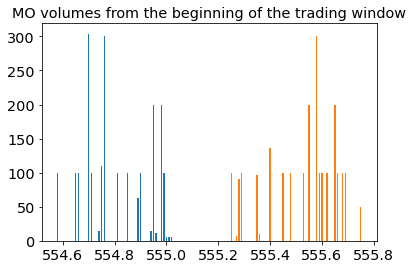

In [13]:
# Volumes: first second of the trading window
print('MO volumes')
print(bidvol[initTime+1,:])
print(askvol[initTime+1,:])
plt.bar(bid[initTime+1,:],bidvol[initTime+1,:],width=0.005)
plt.bar(ask[initTime+1,:],askvol[initTime+1,:],width=0.005)
plt.show
plt.title("MO volumes from the beginning of the trading window")

Text(0.5, 1.0, 'Evolution of the order flow on the trading window')

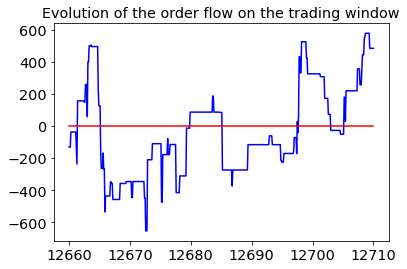

In [14]:
# 0rder flow on the trading window
mean_OF_TW = np.mean(order_flow[initTime:totalTime-thirtyMin])

plt.figure(1)
plt.plot(t[initTime:totalTime-thirtyMin],order_flow[initTime:totalTime-thirtyMin],'b')
plt.plot(t[initTime:totalTime-thirtyMin:10],np.zeros(len(tradingTime)),'r')
plt.title('Evolution of the order flow on the trading window')

<Figure size 432x288 with 0 Axes>

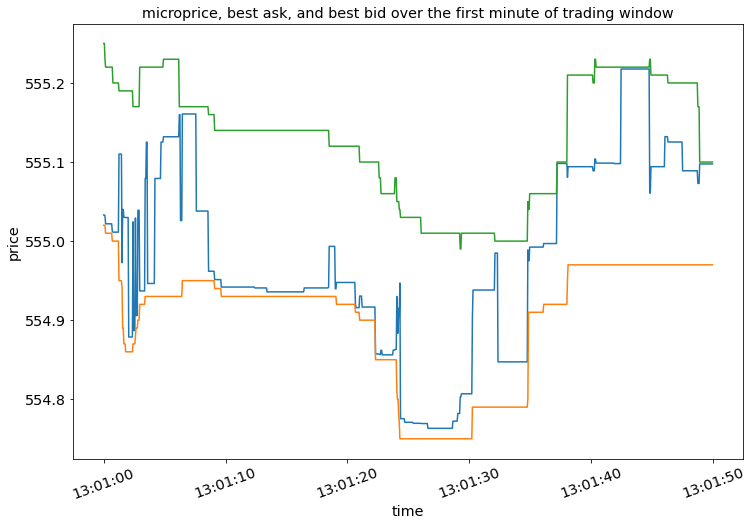

In [15]:
# Evolution of the microprice on the trading window
plt.figure(1)
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(t[initTime:initTime+1000],microprice[initTime:initTime+1000])
plt.plot(t[initTime:initTime+1000],bid[initTime:initTime+1000,0])
plt.plot(t[initTime:initTime+1000],ask[initTime:initTime+1000,0])
plt.title('microprice, best ask, and best bid over the first minute of trading window')
plt.ylabel('price')
plt.xlabel('time')
plt.xticks([12660, 12680, 12700, 12720, 12740, 12760], ['13:01:00', '13:01:10', '13:01:20','13:01:30','13:01:40','13:01:50'], rotation=20)
#plt.xticks([0, 1, 2, 3, 4, 5], ['13:01:00', '13:01:10', '13:01:20','13:01:30','13:01:40','13:01:50'], rotation=20)
plt.savefig('/content/drive/Shared drives/ProjectML/Project/Temporary_Plots_Figures/'+ticker+'/microprice_bestBidAsk_firstminute.png')
plt.show()

### Statistic test for AR 1 model and OLS model - checking the quality of statistical tests

In [16]:
# AR(1) model assumption: first test
# Setting a window 
t_ARtest_est_init = 211*60*10-1     #13:01
t_ARtest_est_31min = 30*60*10       #30 minutes
order_flow_sec_test = order_flow[t_ARtest_est_init-N:t_ARtest_est_init:10]  # backtesting on the estimation window
OF_AR1 = sm.tsa.AutoReg(order_flow_sec_test,1)                              
OF_AR1 = OF_AR1.fit()

OF_AR1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:                   60
Model:                     AutoReg(1)   Log Likelihood                -373.618
Method:               Conditional MLE   S.D. of innovations            136.123
Date:                Thu, 09 Mar 2023   AIC                            753.235
Time:                        06:36:07   BIC                            759.468
Sample:                             1   HQIC                           755.668
                                   60                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         95.1911     44.958      2.117      0.034       7.074     183.308
y.L1           0.7180      0.104      6.882      0.000       0.513       0.922
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3928           +0.0000j            1.3928            0.0000
-----------------------------------------------------------------------------
"""

In [17]:
# Linear Regression between order flow and microprice: second test
# Setting a window 
t_OLStest_est_init = 211*60*10-1
t_OLStest_est_31min = 30*60*10
order_flow_OLStest_list = order_flow[t_OLStest_est_init-N:t_OLStest_est_init:10] # backtesting on the estimation window
microprice_OLStest_list = microprice[t_OLStest_est_init-N:t_OLStest_est_init:10] # backtesting on the estimation window
OLS_model = sm.OLS(np.diff(microprice_OLStest_list),np.diff(order_flow_OLStest_list))
OLS_model = OLS_model.fit()

OLS_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.196
Model:                            OLS   Adj. R-squared (uncentered):              0.182
Method:                 Least Squares   F-statistic:                              14.17
Date:                Thu, 09 Mar 2023   Prob (F-statistic):                    0.000392
Time:                        06:36:07   Log-Likelihood:                          124.29
No. Observations:                  59   AIC:                                     -246.6
Df Residuals:                      58   BIC:                                     -244.5
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0001   2.66e-05      3.764      0.000    4.69e-05       0.000
==============================================================================
Omnibus:                       20.840   Durbin-Watson:                   2.301
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              179.709
Skew:                           0.028   Prob(JB):                     9.48e-40
Kurtosis:                      11.550   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Results on $Δ$Order-Flow and $Δ$Microprice

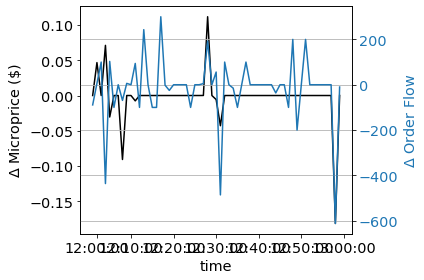

In [18]:
#plt.plot(Xs_test, color='black')
#plt.plot(Xs_test_0_0_1, color='blue')
fig, ax1 = plt.subplots()
color = 'black'
ax1.set_xlabel('time')
ax1.set_ylabel('$\Delta$'+ ' Microprice (\$)', color=color)
ax1.plot(t[t_OLStest_est_init-N:t_OLStest_est_init:10][:-1],np.diff(microprice_OLStest_list), color=color)

ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('$\Delta$' + ' Order Flow', color=color)


linestyle=['-', '--','-.',':']
ax2.plot(t[t_OLStest_est_init-N:t_OLStest_est_init:10][:-1],np.diff(order_flow_OLStest_list), color=color)
#plt.plot(results[0.01]['inventory'], color='green')
ax2.tick_params(axis='y', labelcolor=color)
plt.xticks([12601, 12609, 12619, 12629, 12639, 12649, 12659], ['12:00:00', '12:10:00', '12:20:00','12:30:00','12:40:00','12:50:00', '13:00:00'], rotation=20)

#ax2.set_xticks([t[initTime], t[initTime+10], t[initTime+20], t[initTime+30], t[initTime+40], t[initTime+50]], ['13:01:00', '13:01:10', '13:01:20','13:01:30','13:01:40','13:01:50'], rotation=20)
#plt.ylabel('Inventory (Num. Blocks)')
#plt.xlabel('time')
fig.tight_layout()
plt.grid()
file_path= '/content/drive/Shared drives/ProjectML/Project/Temporary_Plots_Figures/'+ticker+'/'
fig.savefig(file_path+'Delta_OF_dpi1200.eps', format='eps', dpi=1200)
fig.savefig(file_path+'Delta_OF_dpi600.eps', format='eps', dpi=600)
fig.savefig(file_path+'Delta_OF_dpi300.eps', format='eps', dpi=300)



### Parameters for Reinforcement Learning Exploitation

In [19]:
BLOCK_SIZE = 40                     # number of shares in a bloc
NUM_BLOCKS = 100                    # initial number of blocks
NUM_S      = len(micropriceDiscr)   # number of discrete values of S
NUM_TIME_STEPS = len(tradingTime)   # total number of seconds
dt         = 1                      # time step: check every two second
scale      = 10**-6                 # scale for risk aversion param
#lmbda      = 0.5                    # risk aversion parameter: to be tested with different values then (0, 0.01, 1)
p_star1    = 0.05                   # p-values authorized for Dickey-Fuller test
p_star2    = 0.05                   # p-values authorized for the linear regression
TCost      = 0.0030                 # NASDAQ TCost

In [20]:
print(NUM_TIME_STEPS, NUM_S )

51 971


In [21]:
EPSILON = 0.5       # Probability for exploration
ALPHA = 0.5         # Step size
GAMMA = 1           # Discount factor for Q-Learning and Sarsa

In [22]:
# Initial microprice necessary to set the MDP problem (state variable)
S0 = (bid[initTime,0]*askvol[initTime,0]+ask[initTime,0]*bidvol[initTime,0])/(bidvol[initTime,0]+askvol[initTime,0])  # initial microprice
diff_S0 = np.absolute(micropriceDiscr-S0)                                                                   
S0_index = diff_S0.argmin() # closest index in the discretized microprice values
print(S0)
print(S0_index)

555.0330188679245
515


We define the list of possible actions; which is selling a certain number of  blocs of 40 shares.

5 possible actions: [0, 1, 2, 3, 4].

In [23]:
ACTIONS = list(range(0,5))
print(ACTIONS)

[0, 1, 2, 3, 4]


We define the state vector for the initial state: the maximum number of stocks, the initial price $S_0$, and time $t = 0$

In [24]:
START = [NUM_BLOCKS-1, S0_index, 0]

Slippage 

In [25]:
#Preparing TEST SLIPPAGE
print(initTime)
print(bid[initTime,:])
print()
print(ask[initTime,:])
print(bidvol[initTime,0])
print(bidvol[initTime,:nVol_OF]) 


126599
[555.02 555.01 555.   554.99 554.98 554.96 554.95 554.94 554.9  554.89
 554.85 554.81 554.76 554.75 554.74 554.71 554.7  554.66 554.65 554.58]

[555.25 555.27 555.28 555.29 555.35 555.36 555.4  555.45 555.48 555.53
 555.55 555.58 555.59 555.6  555.62 555.65 555.66 555.68 555.69 555.75]
6.0
[  6.   6.   6. 100. 200.  12. 200.  15. 100.  63.]


In [26]:
def compute_slippage(time_step, actionVol, bid_vol, bid_price, TCost, nVol):
  # actionVol is the volume of the actions taken (BLOCK_SIZE * NUMBER_BLOCS)
  # bid_vol is where there all the volumes for bid at each time step
  # bid_price is where there all the quotes for bid at each time step
  # nVol, the number of level we can go through while walking through the book
  bid_vol_clone = np.array(bid_vol)
  level = 0                                                                     # level zero is the best bid
  interPrice = []                                                               # list where is stocked volume*price at each level 
  if actionVol <= bid_vol_clone[time_step,level]:                               # easy case: our volume is lower than the best bid volume
    slippage = actionVol*bid_price[time_step,level]                             
    bid_vol_clone[time_step,level] = bid_vol_clone[time_step,level] - actionVol # update the bid volume on that level
  else: 
    while actionVol >0 and level <= nVol:
      #print("Current Level: ",level)
      #print("Number of shares remaining: ",actionVol)
      interPrice.append(min(actionVol,bid_vol_clone[time_step,level])*(bid_price[time_step,level]-TCost)) # price at the current level * volume
      future_bid_vol_update = actionVol                                                     # intermediate variable to update well the bid volume later
      actionVol = actionVol - bid_vol_clone[time_step,level]                                # upadte on our actions
      bid_vol_clone[time_step,level] = bid_vol_clone[time_step,level] - min(future_bid_vol_update,bid_vol_clone[time_step,level])
      #print("Current level volume: ", bid_vol[time_step,level])
      level += 1                                                                # we go to the next best bid price
    slippage = np.sum(interPrice)
  return slippage


Two tests realized to make sure the slippage function works. \
First test, the volume does not walk the LOB: everything is consumed at the first level (best bid volume).\
Second test, not all shares are executed at the same price, it walks the book.

In [27]:
#test1 = compute_slippage(initTime, 500, bidvol, bid, nVol_OF)
#print(test1)
test2 = compute_slippage(initTime, 800, bidvol, bid, TCost, nVol_OF)
print(test2)

443950.67


In [28]:
# Statistical tests performed before the RL exploitation
# Tests based on the actions of the other participants in the market
price_impact_list = []            # setting the list for all price_impact needed in trading window
intercept_list = []               # setting the list for all intercept needed in trading window
phi_list = []                     # setting the list for all phi needed in trading window

for i in range(len(tradingTime)):
  OF_hat = order_flow[tradingTime[i]*secondFreq-N:tradingTime[i]*secondFreq]
  microprice_hat = microprice[tradingTime[i]*secondFreq-N:tradingTime[i]*secondFreq] 
  phi, sigma = linear_model.yule_walker(OF_hat,order=1)     # Yules-Walker equation
  if abs(phi[0])>1:
      phi[0] = phi[0]/abs(phi[0]) # -1 or 1 according to phi sign
  phi_list.append(phi[0])

  price_impact, intercept, r_value, p_value2, std_err = stats.linregress(np.diff(OF_hat),np.diff(microprice_hat))  # regression between (St) and (OFt)
  price_impact_list.append(price_impact)
  intercept_list.append(intercept)


In [29]:
print(phi_list)
print(price_impact_list)
print(tradingTime*secondFreq)

[0.961602435957551, 0.9663439024385576, 0.9653790195259853, 0.9600656601378373, 0.9635746378576205, 0.9621679598300534, 0.9536420837567032, 0.9641813130158973, 0.9684488101472772, 0.9741226845443068, 0.9769543444629004, 0.979048947741483, 0.9809251450281368, 0.9820290771867779, 0.9830494645411745, 0.9837100811572047, 0.982396546637717, 0.9822417813538129, 0.9806454746425732, 0.9822618530935759, 0.9830576205751609, 0.9825698566785376, 0.9820311301143425, 0.9814352623684564, 0.9815827250594443, 0.9811875918451957, 0.9787554450530417, 0.9787298546960959, 0.9778554877047653, 0.9769709653406052, 0.9754215471087115, 0.980061556969704, 0.9796122637999896, 0.9794619661436702, 0.9790610338131973, 0.9788809998177538, 0.9791482114697353, 0.9787392728507778, 0.9753008083266799, 0.9749221396035943, 0.9756076547775054, 0.9756248439369407, 0.9760937417772895, 0.9756810958833743, 0.9754380008593082, 0.9749559662870396, 0.9729903184449887, 0.9735748164376014, 0.9722407432406833, 0.9715647565517346, 0.9

Step function that describes how the next state is obtained from the current state and the action taken. The function returns the next state and the reward obtained.

In [30]:
def step(state, action):
    reward = 0
    cash = 0
    X, S_index, time_t = state

    if action >= X:                                                             # can't sell more than what is left in the inventory                            
      action = X  
    elif action < X and time_t==len(tradingTime)-2:
      action = X
    
    # Calculate the number of stocks remaining: X_next
    X_next = X - action
    #print("X_next %d action: %d" % (X, action))

    # Order flow window
    order_flow = np.sum(bidvol[:,:nVol_OF],axis=1)-np.sum(askvol[:,:nVol_OF],axis=1) 
    OF_hat = order_flow[tradingTime[time_t]*secondFreq-N:tradingTime[time_t]*secondFreq]   # Order-Flow on the estimation window

    # Slippage computation
    slippage = compute_slippage(time_t, action*BLOCK_SIZE, bidvol, bid, TCost, nVol_OF) 
    cash = slippage  # will be the first part of the reward

    # Next Price
    alpha = price_impact_list[time_t]*(1-phi_list[time_t]**secondFreq)*(OF_hat[-1] - action*BLOCK_SIZE) + intercept_list[time_t]   # expected change predicted with the price impact (the variable price impact contains lambda and phi1)
    S_execution = micropriceDiscr[S_index] + alpha # second part of the reward function: St+1 = current price - expected change predicted with the price impact
    
    S_next = S_execution 
    # Quantise S_next to an allowed value
    if S_next > np.max(micropriceDiscr) or S_next < np.min(micropriceDiscr):
      print("!!! --- error S_next is off the grid --- ")

    difference_array = np.absolute(micropriceDiscr-S_next)
    S_index = difference_array.argmin()
    #print(S_next, np.min(micropriceDiscr), np.max(micropriceDiscr), S_index, S_execution, alpha, tradingTime[time_t]*secondFreq, time_t)
    #print("S_next = %4.2f, S_index=   %4.2f" %(S_next, micropriceDiscr[S_index]))

    # Next State  
    next_state = [X_next, S_index, time_t+dt]
    
    # Calculate the reward earned from the sale    
    reward += cash - scale*lmbda*BLOCK_SIZE**2*(X_next**2)*(S_execution**2)
    
    return next_state, reward, cash

In [31]:
np.min( microprice[tradingTime[0:10]*secondFreq])+0.004, np.max( microprice[tradingTime[0:10]*secondFreq]+0.004)

(554.882679245283, 555.12922875817)

In [32]:
np.min(micropriceDiscr), np.max(micropriceDiscr)

(554.7754545454545, 555.260454545443)

In [33]:
# Check some state, action pairs and the associated reward
# print(step(START, 0))
# print(step([20,100,4], 0))

### Set up the agent's action policy

Given $S_t$ and $Q$, this function chooses an action based on the epsilon-greedy algorithm

In [34]:
# Choose an action based on epsilon greedy algorithm
def choose_action(state, q_value, eps=EPSILON):
    # With probability `eps', simply choose a random action - 'Exploration'
    if np.random.binomial(1, eps) == 1:
        action = np.random.choice(ACTIONS)
    # Otherwise, choose from the actions with the highest
    # q-value for the given state - 'Exploitation'
    else:
        values_ = q_value[state[0], state[1], :]
        action = np.random.choice(
            [action_ for action_, value_ in enumerate(values_) 
                                 if value_ == np.max(values_)])
    # You cannot sell more stocks than you have
    if action > state[0]:
        action = state[0]
    return action

For example, when `q_value` is all zeroes, the action taken is always random:

In [35]:
q_value = np.zeros((NUM_BLOCKS, NUM_S, len(ACTIONS)))
choose_action(START, q_value, EPSILON)

2

### Set up the learning algorithm

#### Sarsa and Expected Sarsa

This function simulates an episode with Sarsa. It takes the state-action value array `q_value` as an argument, initialises the state to `START`, defined above, and updates `q_value` according to the Sarsa algorithm, until the $T$ time steps have passed, or the stocks have all been sold. The cumulative reward earned is returned.

In [36]:
def sarsa(q_value, expected=False, step_size=ALPHA, eps=EPSILON):
    state = START
    action = choose_action(state, q_value,eps)
    rewards = 0.0
    total_cash = 0.0          # accumulate cash earnings during the whole trading period

    while (state[2] < (NUM_TIME_STEPS-1)*dt) and (state[0] > 0):
        next_state, reward, cash = step(state, action)
        next_action = choose_action(next_state, q_value, eps)
        rewards += reward
        total_cash += cash    # accumulate cash earnings during the whole trading period
        if not expected:
            target = q_value[next_state[0], next_state[1], next_action]
        else:
            # Calculate the expected value of new state
            target = 0.0
            q_next = q_value[next_state[0], next_state[1], next_state[2], :]
            best_actions = np.argwhere(q_next == np.max(q_next))
            for action_ in ACTIONS:
                if action_ in best_actions:
                    target += ((1.0 - eps) / len(best_actions) 
                               + eps / len(ACTIONS)) * q_value[next_state[0], next_state[1], next_state[2], action_]
                else:
                    target += eps / len(ACTIONS) * q_value[next_state[0], next_state[1], next_state[2], action_]
        target *= GAMMA
        q_value[state[0], state[1], action] += step_size * (
                reward + target - q_value[state[0], state[1],  action])
        state = next_state
        action = next_action

    #print("state[0] %d" % state[0])    
    return rewards, total_cash

Text(0, 0.5, 'epsilon')

<Figure size 432x288 with 0 Axes>

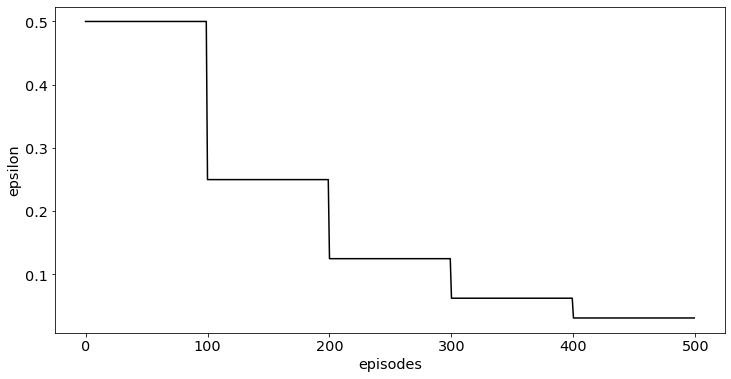

In [37]:
# Epsilon setting
num_episodes = 500
EPOCH=0.2*num_episodes 
list_eps = []
for i in range(0, num_episodes):
  eps_val = EPSILON*((1-EPSILON)**(i//EPOCH))
  list_eps.append(eps_val)

plt.figure()
fig, ax = plt.subplots(figsize=(12,6))
plt.plot(list_eps,'k')
plt.xlabel("episodes")
plt.ylabel('epsilon')

#plt.savefig('/content/drive/Shared drives/ProjectML/Project/Temporary_Plots_Figures/epsilon.png')

### Running Sarsa 

This function will plot the average (over `runs` independent trials) rewards earned by SARSA and Q-learning after each iteration (up to `episodes`).

In [38]:
def trainSarsa(episodes=1000, runs=100, epoches=10):
    EPOCH=epoches
    EPOCH_=0.2*episodes
    
    # Initialise the rewards arrays
    rewards_sarsa = np.zeros(episodes)
    total_cash_list = np.zeros(episodes)
    q_sarsa_avg = np.zeros((NUM_BLOCKS, NUM_S, len(ACTIONS)))
    #q_sarsa_avg = np.zeros((NUM_BLOCKS, NUM_S, len(ACTIONS)))
    for r in tqdm(range(runs)):
        # Initialise the state-action arrays 
        q_sarsa = np.zeros((NUM_BLOCKS, NUM_S,  len(ACTIONS)))
        #q_sarsa = np.zeros((NUM_BLOCKS, NUM_S, len(ACTIONS)))
        # Update the rewards and action value arrays for each episode
        for i in range(0, episodes):
            if i%10 ==0:
               print("episode %d" %i)
            # The value of epsilon is decremented exponentially
            # after every EPOCH episodes
            eps = EPSILON*((1-EPSILON)**(i//EPOCH_))
            rewards, total_cash = sarsa(q_sarsa,eps=eps)
            q_sarsa_avg += q_sarsa
            rewards_sarsa[i] += rewards
            total_cash_list[i] += total_cash
    # Averaging over independent runs
    rewards_sarsa /= runs
    total_cash_list /= runs
    q_sarsa_avg /= runs
    
    # Draw reward curves
    plt.plot(rewards_sarsa, label='Sarsa',color='black')
    plt.xlabel('Episodes')
    plt.ylabel('Sum of rewards during episode')
    plt.legend()

    return q_sarsa_avg, rewards_sarsa, total_cash_list


  0%|          | 0/3 [00:00<?, ?it/s]

episode 0
episode 10
episode 20
episode 30
episode 40
episode 50
episode 60
episode 70
episode 80
episode 90
episode 100
episode 110
episode 120
episode 130
episode 140
episode 150
episode 160
episode 170
episode 180
episode 190
episode 200
episode 210
episode 220
episode 230
episode 240
episode 250
episode 260
episode 270
episode 280
episode 290
episode 300
episode 310
episode 320
episode 330
episode 340
episode 350
episode 360
episode 370
episode 380
episode 390
episode 400
episode 410
episode 420
episode 430
episode 440
episode 450
episode 460
episode 470
episode 480
episode 490


 33%|███▎      | 1/3 [06:18<12:37, 378.50s/it]

episode 0
episode 10
episode 20
episode 30
episode 40
episode 50
episode 60
episode 70
episode 80
episode 90
episode 100
episode 110
episode 120
episode 130
episode 140
episode 150
episode 160
episode 170
episode 180
episode 190
episode 200
episode 210
episode 220
episode 230
episode 240
episode 250
episode 260
episode 270
episode 280
episode 290
episode 300
episode 310
episode 320
episode 330
episode 340
episode 350
episode 360
episode 370
episode 380
episode 390
episode 400
episode 410
episode 420
episode 430
episode 440
episode 450
episode 460
episode 470
episode 480
episode 490


 67%|██████▋   | 2/3 [12:35<06:17, 377.57s/it]

episode 0
episode 10
episode 20
episode 30
episode 40
episode 50
episode 60
episode 70
episode 80
episode 90
episode 100
episode 110
episode 120
episode 130
episode 140
episode 150
episode 160
episode 170
episode 180
episode 190
episode 200
episode 210
episode 220
episode 230
episode 240
episode 250
episode 260
episode 270
episode 280
episode 290
episode 300
episode 310
episode 320
episode 330
episode 340
episode 350
episode 360
episode 370
episode 380
episode 390
episode 400
episode 410
episode 420
episode 430
episode 440
episode 450
episode 460
episode 470
episode 480
episode 490


  0%|          | 0/3 [00:00<?, ?it/s]

episode 0
episode 10
episode 20
episode 30
episode 40
episode 50
episode 60
episode 70
episode 80
episode 90
episode 100
episode 110
episode 120
episode 130
episode 140
episode 150
episode 160
episode 170
episode 180
episode 190
episode 200
episode 210
episode 220
episode 230
episode 240
episode 250
episode 260
episode 270
episode 280
episode 290
episode 300
episode 310
episode 320
episode 330
episode 340
episode 350
episode 360
episode 370
episode 380
episode 390
episode 400
episode 410
episode 420
episode 430
episode 440
episode 450
episode 460
episode 470
episode 480
episode 490


 33%|███▎      | 1/3 [06:05<12:11, 365.72s/it]

episode 0
episode 10
episode 20
episode 30
episode 40
episode 50
episode 60
episode 70
episode 80
episode 90
episode 100
episode 110
episode 120
episode 130
episode 140
episode 150
episode 160
episode 170
episode 180
episode 190
episode 200
episode 210
episode 220
episode 230
episode 240
episode 250
episode 260
episode 270
episode 280
episode 290
episode 300
episode 310
episode 320
episode 330
episode 340
episode 350
episode 360
episode 370
episode 380
episode 390
episode 400
episode 410
episode 420
episode 430
episode 440
episode 450
episode 460
episode 470
episode 480
episode 490


 67%|██████▋   | 2/3 [12:07<06:03, 363.43s/it]

episode 0
episode 10
episode 20
episode 30
episode 40
episode 50
episode 60
episode 70
episode 80
episode 90
episode 100
episode 110
episode 120
episode 130
episode 140
episode 150
episode 160
episode 170
episode 180
episode 190
episode 200
episode 210
episode 220
episode 230
episode 240
episode 250
episode 260
episode 270
episode 280
episode 290
episode 300
episode 310
episode 320
episode 330
episode 340
episode 350
episode 360
episode 370
episode 380
episode 390
episode 400
episode 410
episode 420
episode 430
episode 440
episode 450
episode 460
episode 470
episode 480
episode 490


  0%|          | 0/3 [00:00<?, ?it/s]

episode 0
episode 10
episode 20
episode 30
episode 40
episode 50
episode 60
episode 70
episode 80
episode 90
episode 100
episode 110
episode 120
episode 130
episode 140
episode 150
episode 160
episode 170
episode 180
episode 190
episode 200
episode 210
episode 220
episode 230
episode 240
episode 250
episode 260
episode 270
episode 280
episode 290
episode 300
episode 310
episode 320
episode 330
episode 340
episode 350
episode 360
episode 370
episode 380
episode 390
episode 400
episode 410
episode 420
episode 430
episode 440
episode 450
episode 460
episode 470
episode 480
episode 490


 33%|███▎      | 1/3 [06:45<13:30, 405.28s/it]

episode 0
episode 10
episode 20
episode 30
episode 40
episode 50
episode 60
episode 70
episode 80
episode 90
episode 100
episode 110
episode 120
episode 130
episode 140
episode 150
episode 160
episode 170
episode 180
episode 190
episode 200
episode 210
episode 220
episode 230
episode 240
episode 250
episode 260
episode 270
episode 280
episode 290
episode 300
episode 310
episode 320
episode 330
episode 340
episode 350
episode 360
episode 370
episode 380
episode 390
episode 400
episode 410
episode 420
episode 430
episode 440
episode 450
episode 460
episode 470
episode 480
episode 490


 67%|██████▋   | 2/3 [13:28<06:43, 403.89s/it]

episode 0
episode 10
episode 20
episode 30
episode 40
episode 50
episode 60
episode 70
episode 80
episode 90
episode 100
episode 110
episode 120
episode 130
episode 140
episode 150
episode 160
episode 170
episode 180
episode 190
episode 200
episode 210
episode 220
episode 230
episode 240
episode 250
episode 260
episode 270
episode 280
episode 290
episode 300
episode 310
episode 320
episode 330
episode 340
episode 350
episode 360
episode 370
episode 380
episode 390
episode 400
episode 410
episode 420
episode 430
episode 440
episode 450
episode 460
episode 470
episode 480
episode 490


  0%|          | 0/3 [00:00<?, ?it/s]

episode 0
episode 10
episode 20
episode 30
episode 40
episode 50
episode 60
episode 70
episode 80
episode 90
episode 100
episode 110
episode 120
episode 130
episode 140
episode 150
episode 160
episode 170
episode 180
episode 190
episode 200
episode 210
episode 220
episode 230
episode 240
episode 250
episode 260
episode 270
episode 280
episode 290
episode 300
episode 310
episode 320
episode 330
episode 340
episode 350
episode 360
episode 370
episode 380
episode 390
episode 400
episode 410
episode 420
episode 430
episode 440
episode 450
episode 460
episode 470
episode 480
episode 490


 33%|███▎      | 1/3 [07:14<14:28, 434.02s/it]

episode 0
episode 10
episode 20
episode 30
episode 40
episode 50
episode 60
episode 70
episode 80
episode 90
episode 100
episode 110
episode 120
episode 130
episode 140
episode 150
episode 160
episode 170
episode 180
episode 190
episode 200
episode 210
episode 220
episode 230
episode 240
episode 250
episode 260
episode 270
episode 280
episode 290
episode 300
episode 310
episode 320
episode 330
episode 340
episode 350
episode 360
episode 370
episode 380
episode 390
episode 400
episode 410
episode 420
episode 430
episode 440
episode 450
episode 460
episode 470
episode 480
episode 490


 67%|██████▋   | 2/3 [14:29<07:14, 434.62s/it]

episode 0
episode 10
episode 20
episode 30
episode 40
episode 50
episode 60
episode 70
episode 80
episode 90
episode 100
episode 110
episode 120
episode 130
episode 140
episode 150
episode 160
episode 170
episode 180
episode 190
episode 200
episode 210
episode 220
episode 230
episode 240
episode 250
episode 260
episode 270
episode 280
episode 290
episode 300
episode 310
episode 320
episode 330
episode 340
episode 350
episode 360
episode 370
episode 380
episode 390
episode 400
episode 410
episode 420
episode 430
episode 440
episode 450
episode 460
episode 470
episode 480
episode 490


100%|██████████| 3/3 [21:42<00:00, 434.00s/it]


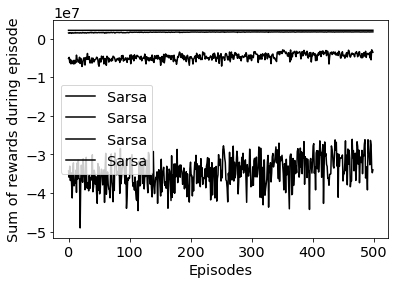

In [39]:
q_sarsa = {}
rewards_sarsa = {}
total_cash_list = {}
lmbda_list = [0.001,0.01, 0.1,0.5]

for lmbda in lmbda_list:
  q_sarsa[lmbda], rewards_sarsa[lmbda], total_cash_list[lmbda] = trainSarsa(500, 3, 50)
  df_rewards_sarsa = pd.DataFrame(rewards_sarsa[lmbda])
  rewards_file_name = "rewards_lmbda_" + str(lmbda) +".csv"
  df_rewards_sarsa.to_csv("/content/drive/Shared drives/ProjectML/Project/Results/"+ticker+"/Rewards/" + rewards_file_name)
  np.save('/content/drive/Shared drives/ProjectML/Project/Q-matrices/'+ticker+'/qmatrix_lmbda_' + str(lmbda) + '.npy', q_sarsa[lmbda])

In [ ]:
df_rewards_sarsa = pd.DataFrame(rewards_sarsa)
rewards_file_name = "rewards_lmbda_" + str(lmbda) +".csv"
df_rewards_sarsa.to_csv("/content/drive/Shared drives/ProjectML/Project/Results/Rewards/" + rewards_file_name)
#!cp rewards_file_name "/content/drive/Shared drives/ProjectML/Project/Results/Rewards"

In [ ]:
# Save Q-Matrix:

#Binary data
np.save('/content/drive/Shared drives/ProjectML/Project/Figures/qmatrix_lmbda_' + str(lmbda) + '.npy', q_sarsa)

In [ ]:
# Load the Q-matrix
figure_folder_matrix = "/content/drive/Shared drives/ProjectML/Project/Figures"
path = "%s/%s" % (figure_folder_matrix,'qmatrix_01_100sec.npy')
q_matrix_lmbda01 = np.load(path)
path = "%s/%s" % (figure_folder_matrix,'qmatrix_1_100sec.npy')
q_matrix_lmbda1 = np.load(path)
path = "%s/%s" % (figure_folder_matrix,'qmatrix_10_100sec.npy')
q_matrix_lmbda10 = np.load(path)
path = "%s/%s" % (figure_folder_matrix,'qmatrix_100_100sec.npy')
q_matrix_lmbda100 = np.load(path)

q_file_name = 'qmatrix_lmbda_' + str(lmbda) + '.npy'
path = "%s/%s" % (figure_folder_matrix,q_file_name)
q_matrix_test = np.load(path)

In [ ]:
# Investigation of the optimal policy
s_0 = S0_index
X_0 = NUM_BLOCKS

s_test = s_0
X_test = X_0
acc_reward_test = 0                                                             # accumalated rewards under the optimal policy
acc_cash_test = 0                                                               # accumalated cash under the optimal policy
Xs_test = [X_0]
reward_process_test = [0]
cash_process_test = [0]
a_star_process_test = []

for time_t in range(NUM_TIME_STEPS):
  a_star_test = q_matrix_test[X_test-1,s_test,:].argmax()                       # getting optimal policy - optimal action
  a_star_process_test.append(a_star_test)
  next_state_test, reward_test, cash_test = step([X_test,s_test,time_t],a_star_test)
  X_test = next_state_test[0]
  Xs_test.append(X_test)
  s_test = next_state_test[1]
  acc_reward_test += reward_test
  reward_process_test.append(acc_reward_test)
  acc_cash_test += cash_test
  cash_process_test.append(acc_cash_test)



Results \& Figures

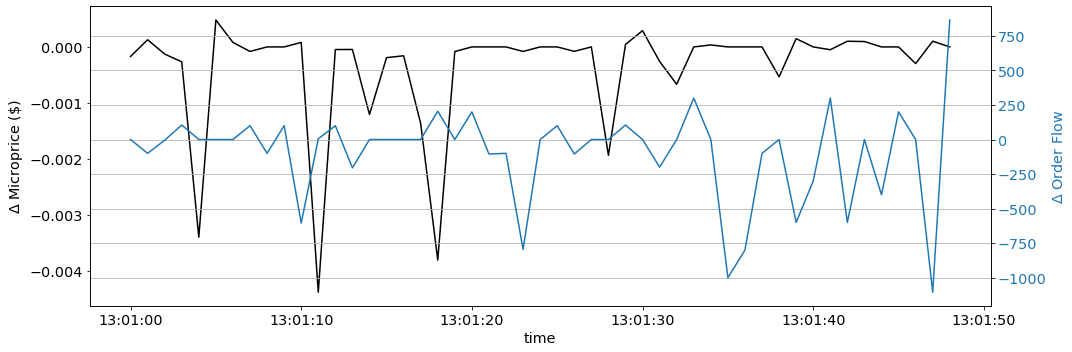

In [ ]:
#plt.plot(Xs_test, color='black')
#plt.plot(Xs_test_0_0_1, color='blue')
fig, ax1 = plt.subplots()
color = 'black'
ax1.set_xlabel('time')
ax1.set_ylabel('$\Delta$' + ' Microprice (\$)', color=color)
ax1.plot(t[initTime:initTime+49], np.diff(microprice[tradingTime[0:50]*secondFreq]), color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('$\Delta$' + ' Order Flow', color=color)


linestyle=['-', '--','-.',':']
ax2.plot(t[initTime:initTime+49],np.diff(order_flow[initTime:initTime+50]), color=color, linestyle=linestyle[0], label='Order Flow')

#plt.plot(results[0.01]['inventory'], color='green')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_xticks([t[initTime], t[initTime+10], t[initTime+20], t[initTime+30], t[initTime+40], t[initTime+50]], ['13:01:00', '13:01:10', '13:01:20','13:01:30','13:01:40','13:01:50'], rotation=20)
#plt.ylabel('Inventory (Num. Blocks)')
#plt.xlabel('time')
fig.tight_layout()
#plt.legend()
plt.grid()
fig.savefig('OF_dpi1200.eps', format='eps', dpi=1200)
fig.savefig('OF_dpi600.eps', format='eps', dpi=600)
fig.savefig('OF_dpi300.eps', format='eps', dpi=300)



In [ ]:
results={}

In [ ]:
results[lmbda]={}
results[lmbda]['cash']= cash_process_test
results[lmbda]['reward']= reward_process_test
results[lmbda]['inventory']= Xs_test

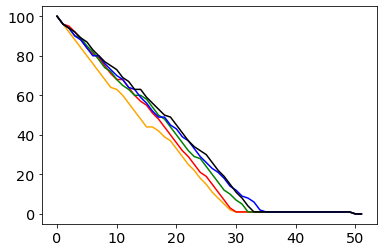

In [ ]:

#plt.plot(results[1]['inventory'])
plt.plot(results[0.5]['inventory'], color='orange')
plt.plot(results[0.1]['inventory'], color='red')
plt.plot(results[0.01]['inventory'], color='green')
plt.plot(results[0.001]['inventory'], color='blue')
plt.plot(results[0.0001]['inventory'], color='black')

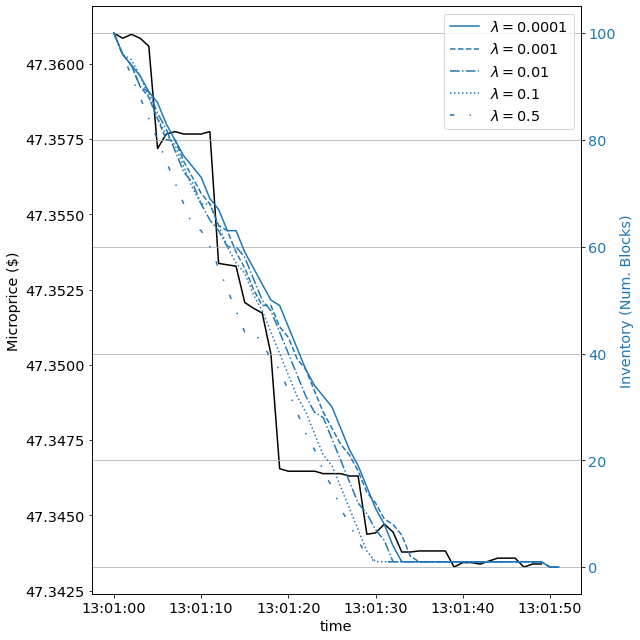

In [ ]:
#plt.plot(Xs_test, color='black')
#plt.plot(Xs_test_0_0_1, color='blue')

fig, ax1 = plt.subplots(figsize=(9, 9))
color = 'black'
ax1.set_xlabel('time')
ax1.set_ylabel('Microprice ($)', color=color)
ax1.plot(t[initTime:initTime+50], microprice[tradingTime[0:50]*secondFreq], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Inventory (Num. Blocks)', color=color)


linestyle=['-', '--','-.',':',(0, (3, 10, 1, 10))]
ax2.plot(t[initTime:initTime+52],results[0.0001]['inventory'], color=color, linestyle=linestyle[0], label='$\lambda=0.0001$')
ax2.plot(t[initTime:initTime+52],results[0.001]['inventory'], color=color,linestyle=linestyle[1], label='$\lambda=0.001$')

#plt.plot(results[0.01]['inventory'], color='green')
ax2.tick_params(axis='y', labelcolor=color)
ax2.plot(t[initTime:initTime+52],results[0.01]['inventory'], color=color, linestyle=linestyle[2], label='$\lambda=0.01$')
ax2.plot(t[initTime:initTime+52],results[0.1]['inventory'], color=color, linestyle=linestyle[3],  label='$\lambda=0.1$')
ax2.plot(t[initTime:initTime+52],results[0.5]['inventory'], color=color, linestyle=linestyle[4],  label='$\lambda=0.5$')
ax2.set_xticks([t[initTime], t[initTime+10], t[initTime+20], t[initTime+30], t[initTime+40], t[initTime+50]], ['13:01:00', '13:01:10', '13:01:20','13:01:30','13:01:40','13:01:50'], rotation=20)
#plt.ylabel('Inventory (Num. Blocks)')
#plt.xlabel('time')
fig.tight_layout()
plt.legend()
plt.grid()
fig.savefig('inventory_dpi1200.eps', format='eps', dpi=1200)
fig.savefig('inventory_dpi600.eps', format='eps', dpi=600)
fig.savefig('inventory_dpi300.eps', format='eps', dpi=300)



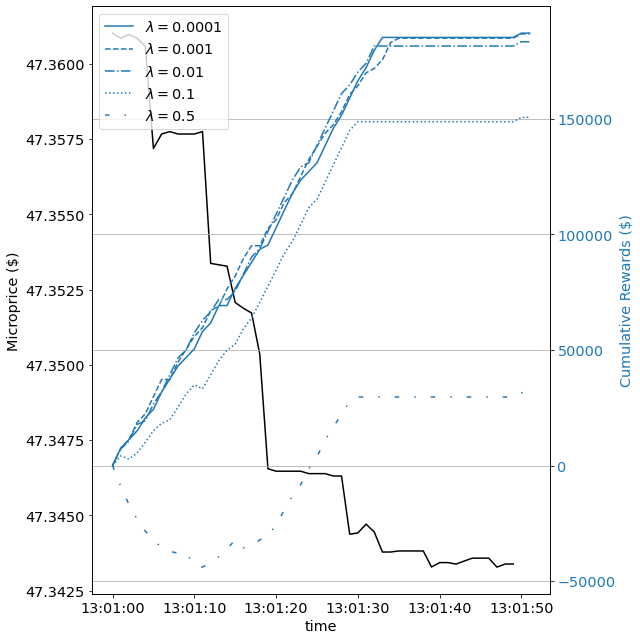

In [ ]:
fig, ax1 = plt.subplots(figsize=(9, 9))
color = 'black'
ax1.set_xlabel('time')
ax1.set_ylabel('Microprice ($)', color=color)
ax1.plot(t[initTime:initTime+50], microprice[tradingTime[0:50]*secondFreq], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Cumulative Rewards ($)', color=color)


linestyle=['-', '--','-.',':',(0, (3, 10, 1, 10))]
ax2.plot(t[initTime:initTime+52],results[0.0001]['reward'], color=color, linestyle=linestyle[0], label='$\lambda=0.0001$')
ax2.plot(t[initTime:initTime+52],results[0.001]['reward'], color=color,linestyle=linestyle[1], label='$\lambda=0.001$')

#plt.plot(results[0.01]['inventory'], color='green')
ax2.tick_params(axis='y', labelcolor=color)
ax2.plot(t[initTime:initTime+52],results[0.01]['reward'], color=color, linestyle=linestyle[2], label='$\lambda=0.01$')
ax2.plot(t[initTime:initTime+52],results[0.1]['reward'], color=color, linestyle=linestyle[3],  label='$\lambda=0.1$')
ax2.plot(t[initTime:initTime+52],results[0.5]['reward'], color=color, linestyle=linestyle[4],  label='$\lambda=0.5$')

ax2.set_xticks([t[initTime], t[initTime+10], t[initTime+20], t[initTime+30], t[initTime+40], t[initTime+50]], ['13:01:00', '13:01:10', '13:01:20','13:01:30','13:01:40','13:01:50'], rotation=20)
#plt.ylabel('Inventory (Num. Blocks)')
#plt.xlabel('time')
fig.tight_layout()
plt.legend()
plt.grid()
fig.savefig('reward_dpi1200.eps', format='eps', dpi=1200)
fig.savefig('reward_dpi600.eps', format='eps', dpi=600)
fig.savefig('reward_dpi300.eps', format='eps', dpi=300)

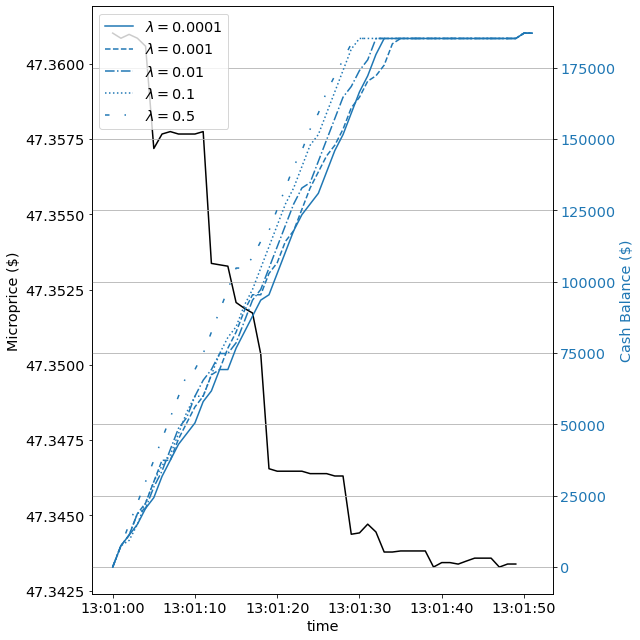

In [ ]:
fig, ax1 = plt.subplots(figsize=(9, 9))

color = 'black'
ax1.set_xlabel('time')
ax1.set_ylabel('Microprice ($)', color=color)
ax1.plot(t[initTime:initTime+50], microprice[tradingTime[0:50]*secondFreq], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Cash Balance ($)', color=color)


linestyle=['-', '--','-.',':',(0, (3, 10, 1, 10))]
ax2.plot(t[initTime:initTime+52],results[0.0001]['cash'], color=color, linestyle=linestyle[0], label='$\lambda=0.0001$')
ax2.plot(t[initTime:initTime+52],results[0.001]['cash'], color=color,linestyle=linestyle[1], label='$\lambda=0.001$')

#plt.plot(results[0.01]['inventory'], color='green')
ax2.tick_params(axis='y', labelcolor=color)
ax2.plot(t[initTime:initTime+52],results[0.01]['cash'], color=color, linestyle=linestyle[2], label='$\lambda=0.01$')
ax2.plot(t[initTime:initTime+52],results[0.1]['cash'], color=color, linestyle=linestyle[3],  label='$\lambda=0.1$')
ax2.plot(t[initTime:initTime+52],results[0.5]['cash'], color=color, linestyle=linestyle[4],  label='$\lambda=0.5$')

ax2.set_xticks([t[initTime], t[initTime+10], t[initTime+20], t[initTime+30], t[initTime+40], t[initTime+50]], ['13:01:00', '13:01:10', '13:01:20','13:01:30','13:01:40','13:01:50'], rotation=20)
#plt.ylabel('Inventory (Num. Blocks)')
#plt.xlabel('time')
fig.tight_layout()
plt.legend()
plt.grid()
fig.savefig('cash_dpi1200.eps', format='eps', dpi=1200)
fig.savefig('cash_dpi600.eps', format='eps', dpi=600)
fig.savefig('cash_dpi300.eps', format='eps', dpi=300)

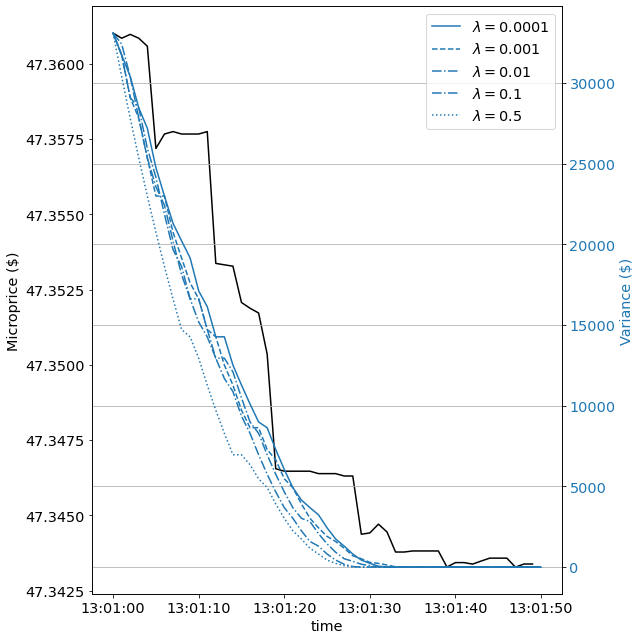

In [ ]:
fig, ax1 = plt.subplots(figsize=(9, 9))
color = 'black'
ax1.set_xlabel('time')
ax1.set_ylabel('Microprice ($)', color=color)
ax1.plot(t[initTime:initTime+50], microprice[tradingTime[0:50]*secondFreq], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Variance ($)', color=color)
ax2.tick_params(axis='y', labelcolor=color)

linestyle=['-', '--','-.',':',(0, (3, 10, 1, 10))]
#ax2.plot(t[initTime:initTime+52],results[0]['inventory'], color=color, linestyle=linestyle[0], label='$\lambda=0$')
ax2.plot(t[initTime:initTime+51],np.diff((np.array(results[0.0001]['cash'])-np.array(results[0.0001]['reward']))/0.0001), color=color,linestyle=linestyle[0], label='$\lambda=0.0001$')

#plt.plot(results[0.01]['inventory'], color='green')
ax2.plot(t[initTime:initTime+51],np.diff((np.array(results[0.001]['cash'])-np.array(results[0.001]['reward']))/0.001), color=color, linestyle=linestyle[1], label='$\lambda=0.001$')
ax2.plot(t[initTime:initTime+51],np.diff((np.array(results[0.01]['cash'])-np.array(results[0.01]['reward']))/0.01), color=color, linestyle=linestyle[2], label='$\lambda=0.01$')
ax2.plot(t[initTime:initTime+51],np.diff((np.array(results[0.1]['cash'])-np.array(results[0.1]['reward']))/0.1), color=color, linestyle=linestyle[2],  label='$\lambda=0.1$')
ax2.plot(t[initTime:initTime+51],np.diff((np.array(results[0.5]['cash'])-np.array(results[0.5]['reward']))/0.5), color=color, linestyle=linestyle[3],  label='$\lambda=0.5$')

ax2.set_xticks([t[initTime], t[initTime+10], t[initTime+20], t[initTime+30], t[initTime+40], t[initTime+50]], ['13:01:00', '13:01:10', '13:01:20','13:01:30','13:01:40','13:01:50'], rotation=20)
#plt.ylabel('Inventory (Num. Blocks)')
#plt.xlabel('time')
fig.tight_layout()
plt.legend()
plt.grid()
fig.savefig('variance_dpi1200.eps', format='eps', dpi=1200)
fig.savefig('variance_dpi600.eps', format='eps', dpi=600)
fig.savefig('variance_dpi300.eps', format='eps', dpi=300)



In [ ]:
costs=NUM_BLOCKS*BLOCK_SIZE*microprice[tradingTime[0]*secondFreq] -[results[0.0001]['cash'][-1], results[0.001]['cash'][-1], results[0.01]['cash'][-1], results[0.1]['cash'][-1], results[0.5]['cash'][-1], results[1]['cash'][-1]]

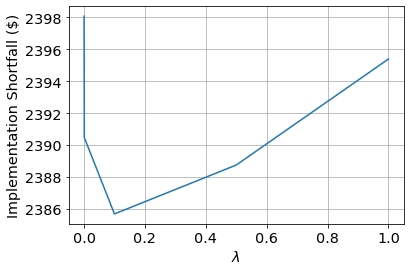

In [ ]:

fig = plt.figure()
#plt.plot(, costs[[0,1,3,4,5]], color='black')
x=[0.0001,0.001,0.1,0.5,1]
y=costs[[0,1,3,4,5]]
poly = np.polyfit(x, y, deg=2)
model1 = np.poly1d(np.polyfit(x, y, 3))
plt.plot(x,y)
#plt.plot(x,model1(x))
plt.ylabel("Implementation Shortfall ($)")
plt.xlabel('$\lambda$')
plt.grid()
fig.savefig('IS_dpi1200.eps', format='eps', dpi=1200)
fig.savefig('IS_dpi600.eps', format='eps', dpi=600)
fig.savefig('IS_dpi300.eps', format='eps', dpi=300)


In [ ]:
NUM_BLOCKS*BLOCK_SIZE*microprice[tradingTime[0]*secondFreq] -results[0.01]['cash'][-1]

187043.87999999998

In [ ]:
results[0.1]['cash'][-1]

187052.6

In [ ]:
results[0.5]['cash'][-1]

187051.63999999998

In [ ]:
results[1]['cash'][-1]

187057.83999999997

Comparing with TWAP

In [ ]:
trading_time_indx = tradingTime - tradingTime[0]
trading_time_indx = [ int(x) for x in tradingTime ] #[int(x) for x in len(trading_time)]
print(trading_time_indx)

In [ ]:
Q0 = NUM_BLOCKS*BLOCK_SIZE
terminal_cash = []
cash_t = 0
for i in trading_time_indx:
    cash_t += (Q0/len(trading_time_indx))*(midprice[i+1]-0.1)
    terminal_cash.append(cash_t)

print(terminal_cash[-1])
plt.plot(trading_time_indx,terminal_cash)